This is the companion file to convert_woa_2013_v2_mat_to_double_binary.m

convert_woa_2013_v2_mat_to_double_binary.m read in the TS climatology file

/home/ifenty/data/observations/TS_climatology/WOA_2013_V2/1995-2014-merged/WOA13_v2_TS_clim_merged_with_potential_T.mat

and exported all of the structure arrays to big endian, double precision binary in row-first format
** note matlab saves column first by default so I had to first permute the matrix in reverse order in the matlab script

here we load in all of the binary arrays, reshape them to their proper dimension, sanity check the fields, and then use xarray to combine them into a single netcdf.



In [1]:
import scipy.io
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt 
from pprint import pprint

In [2]:
def show_3d_field(vars, var):
    f, axs = plt.subplots(3,3, figsize=[10,6]);
    axs = axs.ravel();
    c= 0
    for m in [3, 6, 9]:
        for k in [1, 25, 60]:
            
            axs[c].imshow(vars[var][m,k,:] , origin='lower', cmap='jet')
            axs[c].imshow(vars[var][m,k,:] , origin='lower', cmap='jet')
            axs[c].imshow(vars[var][m,k,:] , origin='lower', cmap='jet')
            axs[c].set_title(f'month {m} level {k}')
            c+=1
    
    f, axs = plt.subplots(3,3, figsize=[10,6]);
    axs = axs.ravel();
    c= 0
    for m in [3, 6, 9]:
        for k in [1, 25, 60]:
            tmp_mean = np.mean(vars[var][:,k,:], axis=0)
            
            axs[c].imshow(vars[var][m,k,:]-tmp_mean, origin='lower', cmap='jet')
            axs[c].imshow(vars[var][m,k,:]-tmp_mean, origin='lower', cmap='jet')
            axs[c].imshow(vars[var][m,k,:]-tmp_mean, origin='lower', cmap='jet')
            axs[c].set_title(f'month {m} level {k}')
            c+=1

In [3]:
# get list of binary files in directory
p = Path('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology')
files = list(p.glob('*bin'))
pprint(files)

[PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_lon.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_depth.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_S_monthly.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_lon_bnds.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_T_monthly.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_lat_bnds.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_potential_T_monthly.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_lat.bin'),
 PosixPath('/home/sweet/Desktop/ECCO-Insitu-Ian/Matlab-Dependents/TS Climatology/WOA_2013_v2_depth_bnds.bin')]


In [4]:
# load every binary array in the directory
vars = dict()
for f in files:
    # format is double precision, big endian
    vars[f.name.split('WOA_2013_v2_')[1].split('.bin')[0]] = np.fromfile(f, dtype='>f8')

In [5]:
# print length of every binary array
for k, item in vars.items():
    print(k, len(item))

lon 360
depth 102
S_monthly 79315200
lon_bnds 720
T_monthly 79315200
lat_bnds 360
potential_T_monthly 79315200
lat 180
depth_bnds 204


In [6]:
# reshape the flat arrays to the dimensions month, depth, lat, lon
var = 'T_monthly'
vars[var] = np.reshape(vars[var],[12,102,180,360])
var = 'S_monthly'
vars[var] = np.reshape(vars[var],[12,102,180,360])
var = 'potential_T_monthly'
vars[var] = np.reshape(vars[var],[12,102,180,360])

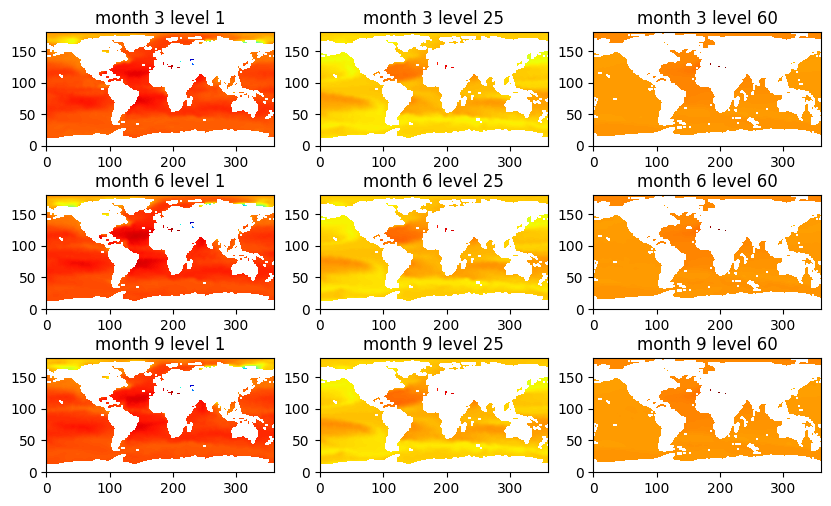

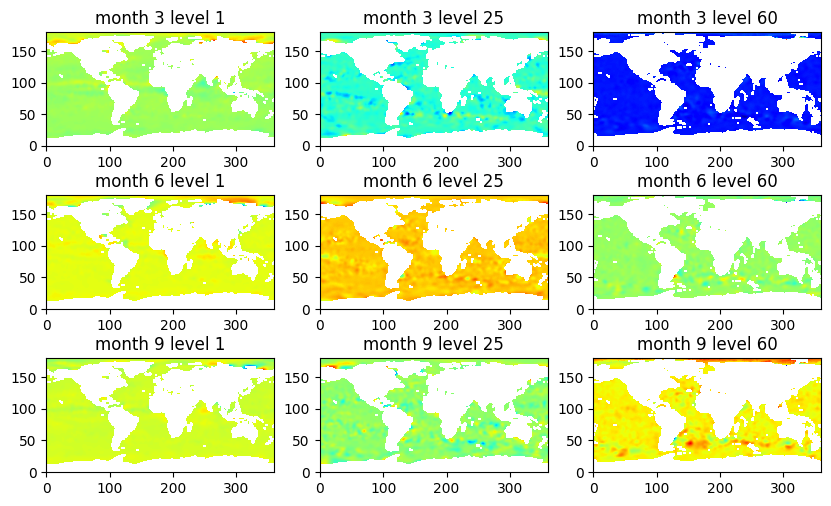

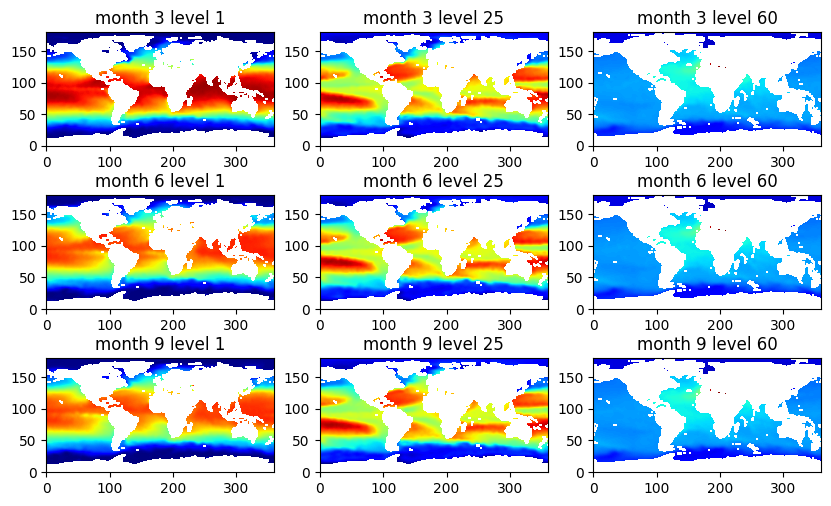

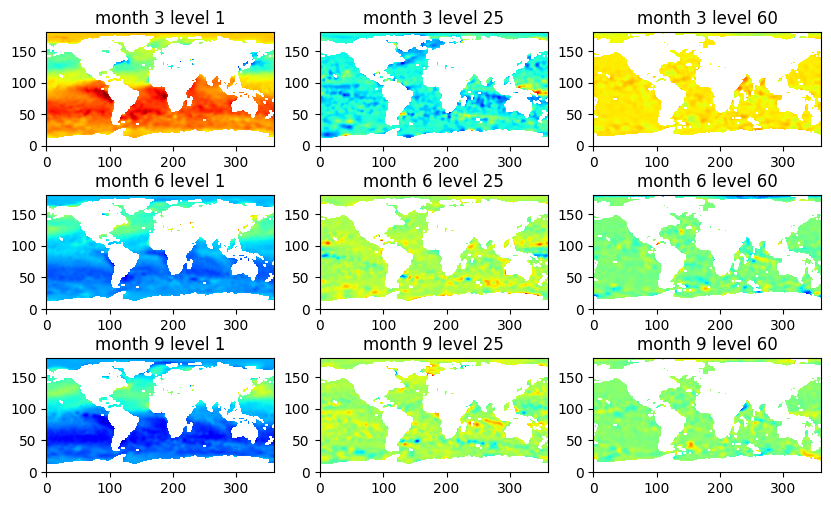

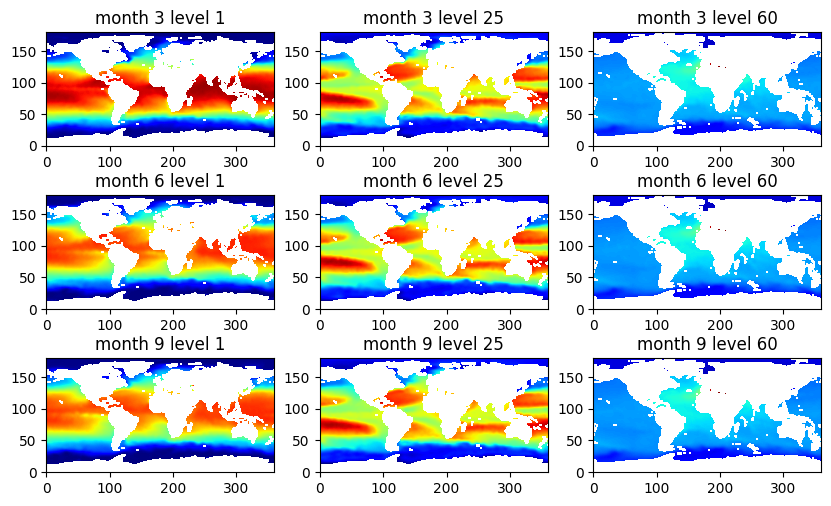

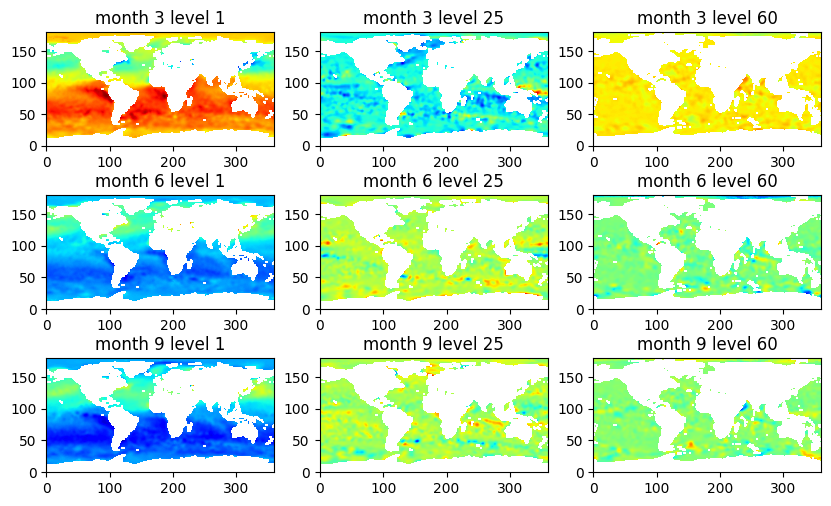

In [7]:
# sanity check that the new fields are Earth
var = 'S_monthly'
show_3d_field(vars, var)
var = 'T_monthly'
show_3d_field(vars, var)
var = 'potential_T_monthly'
show_3d_field(vars, var)

In [8]:
# reshape the 'bounds' arrays.  the second dimension is 2 (upper and lower bound)
var = 'depth_bnds'
vars[var] = np.reshape(vars[var],[102, 2])
print(vars[var][:5,:])
var = 'lat_bnds'
vars[var] = np.reshape(vars[var],[180, 2])
print(vars[var][:5,:])
var = 'lon_bnds'
vars[var] = np.reshape(vars[var],[360, 2])
print(vars[var][:5,:])

[[ 0.   2.5]
 [ 2.5  7.5]
 [ 7.5 12.5]
 [12.5 17.5]
 [17.5 22.5]]
[[-90. -89.]
 [-89. -88.]
 [-88. -87.]
 [-87. -86.]
 [-86. -85.]]
[[-180. -179.]
 [-179. -178.]
 [-178. -177.]
 [-177. -176.]
 [-176. -175.]]


In [9]:
# show first 5 elements of 
# depth of level
print(vars['depth'][:5])
# lat/lons
print(vars['lat'][:5])
print(vars['lon'][:5])

[ 0.  5. 10. 15. 20.]
[-89.5 -88.5 -87.5 -86.5 -85.5]
[-179.5 -178.5 -177.5 -176.5 -175.5]


In [10]:
# convert arrays to a single, beautiful netcdf
import xarray as xr;
pt_da = xr.DataArray(vars['potential_T_monthly'], dims=['month','depth','lat','lon'], 
                      coords={'month':range(12), 'depth':vars['depth'], 
                              'lat':vars['lat'], 'lon':vars['lon']})
pt_da.name='potential_T_monthly'

t_da = xr.DataArray(vars['T_monthly'], dims=['month','depth','lat','lon'], 
                      coords={'month':range(12), 'depth':vars['depth'], 
                              'lat':vars['lat'], 'lon':vars['lon']})
t_da.name='T_monthly'

s_da = xr.DataArray(vars['S_monthly'], dims=['month','depth','lat','lon'], 
                      coords={'month':range(12), 'depth':vars['depth'], 
                              'lat':vars['lat'], 'lon':vars['lon']})
s_da.name='S_monthly'

db_da = xr.DataArray(vars['depth_bnds'], dims=['depth','db'])
db_da.name='depth_bnds'

lonb_da = xr.DataArray(vars['lon_bnds'], dims=['lon','db'])
lonb_da.name='lon_bnds'

latb_da = xr.DataArray(vars['lat_bnds'], dims=['lat','db'])
latb_da.name='lat_bnds'

tmp_ds= xr.merge([pt_da, t_da, s_da, db_da, lonb_da, latb_da])
tmp_ds.depth.attrs['units']='m'
tmp_ds= tmp_ds.set_coords(['depth_bnds', 'lat_bnds','lon_bnds'])
tmp_ds.attrs['source'] = 'WOA13_v2_TS_clim_merged_with_potential_T.mat'
tmp_ds.to_netcdf(p / 'WOA13_v2_TS_clim_merged_with_potential_T.nc')
tmp_ds.close()


In [11]:
# clear tmp_ds and re-load the netcdf to make sure saving worked
tmp_ds = []
tmp_ds = xr.open_dataset(str(p / 'WOA13_v2_TS_clim_merged_with_potential_T.nc'))

In [12]:
tmp_ds

<xarray.Dataset>
Dimensions:              (month: 12, depth: 102, lat: 180, lon: 360, db: 2)
Coordinates:
  * month                (month) int64 0 1 2 3 4 5 6 7 8 9 10 11
  * depth                (depth) float64 0.0 5.0 10.0 ... 5.4e+03 5.5e+03
  * lat                  (lat) float64 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon                  (lon) float64 -179.5 -178.5 -177.5 ... 178.5 179.5
    depth_bnds           (depth, db) float64 ...
    lon_bnds             (lon, db) float64 ...
    lat_bnds             (lat, db) float64 ...
Dimensions without coordinates: db
Data variables:
    potential_T_monthly  (month, depth, lat, lon) float64 ...
    T_monthly            (month, depth, lat, lon) float64 ...
    S_monthly            (month, depth, lat, lon) float64 ...
Attributes:
    source:   WOA13_v2_TS_clim_merged_with_potential_T.mat

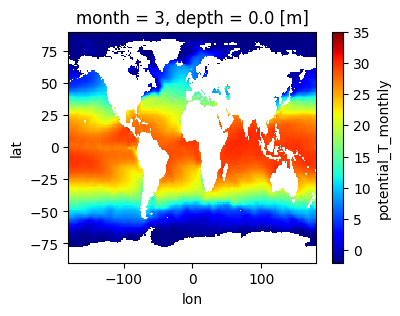

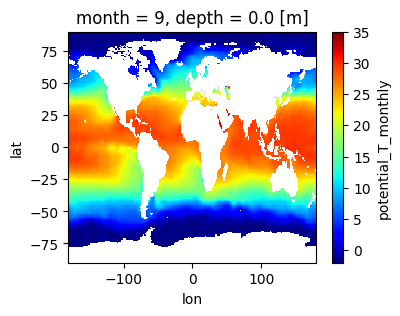

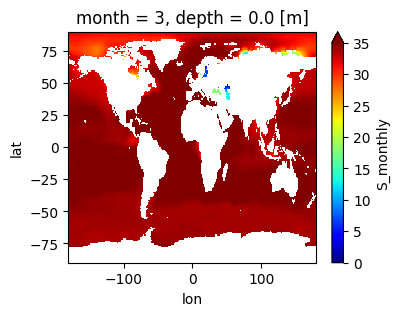

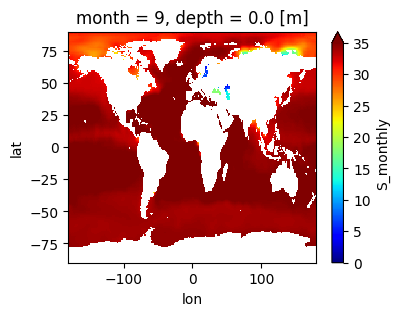

In [13]:
plt.figure(figsize=[4,3]);
tmp_ds.potential_T_monthly[3,0].plot(vmin=-2,vmax=35, cmap='jet')
plt.figure(figsize=[4,3]);
tmp_ds.potential_T_monthly[9,0].plot(vmin=-2,vmax=35, cmap='jet')

plt.figure(figsize=[4,3]);
tmp_ds.S_monthly[3,0].plot(vmin=0,vmax=35, cmap='jet')
plt.figure(figsize=[4,3]);
tmp_ds.S_monthly[9,0].plot(vmin=0,vmax=35, cmap='jet')

In [16]:
# success